# Решение задачи "Сегментация абонентов по трем категориям"

In [2]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from mlxtend.evaluate import lift_score


%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
# Функция вывода метрик: F1, Lift
def print_scores(name, model, X_test, y_test):
    kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    metrics = {
        "lift": make_scorer(lift_score),
        "f1": make_scorer(f1_score, average="macro")
    }
    score = cross_validate(model, X_test, y_test, scoring=metrics, cv=kfold)
    print(f"Model - {name}: F1(macro) - {np.mean(score['test_f1'])}, Lift - {np.mean(score['test_lift'])}")

## Загружаем данные

In [4]:
df = pd.read_csv ("contest_train.csv")
df_saved = df
df.head()

,ID,TARGET,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,1053371037,1,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-114.527812,...,39.0,2.0,223.118594,290.015143,1.0,1.0,0.0,1.0,2.0,2.0
1,76507184,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,329.828334,...,25.0,82.0,479.616045,611.651594,0.0,1.0,0.0,1.0,1.0,1.0
2,76753690,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,...,119.0,0.0,352.268014,564.573421,1.0,1.0,0.0,1.0,1.0,1.0
3,1026167358,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.621397,...,1.0,0.0,410.524985,421.653876,1.0,0.0,0.0,1.0,2.0,2.0
4,7220095746,0,4.0,3.0,1.0,0.0,1.0,0.0,0.0,677.745861,...,21.0,0.0,439.171356,476.189288,1.0,1.0,0.0,1.0,1.0,1.0


Исследуем данные по описательным статистикам.
Можем заметить, что некоторые из характеристик имеют довольно большое стандартное отклонение, для того, чтобы лучше обучить модели, их нужно будет отшкалировать.


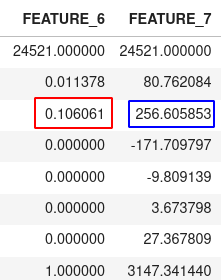

In [5]:
df.describe()

,ID,TARGET,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
count,2.452100e+04,24521.000000,24521.000000,24521.000000,24521.000000,24521.0,24521.000000,24521.000000,24521.000000,24521.000000,...,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.0,24521.000000,24521.00000,24521.000000
mean,1.393464e+09,0.352677,5.438196,1.337833,0.056401,0.0,0.141226,0.000163,0.011378,80.762084,...,41.057379,36.403205,307.827071,408.052350,0.611965,0.640390,0.0,1.138575,1.18580,1.184699
std,1.981725e+09,0.592092,14.533334,1.826413,0.230698,0.0,0.348262,0.012771,0.106061,256.605853,...,105.000146,105.872566,259.669681,349.968987,0.487312,0.479896,0.0,0.373638,0.40809,0.401288
min,1.428335e+07,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-171.709797,...,-1256.000000,-667.000000,-1531.063435,-328.361649,0.000000,0.000000,0.0,1.000000,0.00000,1.000000
25%,4.503249e+08,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-9.809139,...,0.000000,0.000000,129.829124,179.694989,0.000000,0.000000,0.0,1.000000,1.00000,1.000000
50%,7.449749e+08,0.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.673798,...,6.000000,0.000000,265.472906,326.928038,1.000000,1.000000,0.0,1.000000,1.00000,1.000000
75%,1.152479e+09,1.000000,5.000000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,27.367809,...,39.000000,10.000000,408.197249,533.731611,1.000000,1.000000,0.0,1.000000,1.00000,1.000000
max,1.043892e+10,2.000000,385.000000,39.000000,1.000000,0.0,1.000000,1.000000,1.000000,3147.341440,...,1775.000000,3194.000000,4202.905396,4440.534979,1.000000,1.000000,0.0,3.000000,3.00000,3.000000


Отчистим данные от возможных nan (not a number), иначе модели не смогут обучиться, а просто выбросят ошибку.

In [6]:
df.shape

(24521, 262)

Видим, если будем удалять наблюдения (строки данных) из-за каждого nan, то останется только 211 наблюдений. Довольно большая потеря, считая, что изначально имели - 24521.

In [5]:
df.dropna(axis=0).shape

(211, 262)

Попробуем удалять не наблюдения, а характеристики (колонки). Осталось 209 из 262 - небольшая потеря, по сравнению с потерей наблюдений.

In [6]:
df.dropna(axis=1).shape

(24521, 209)

In [7]:
df = df.dropna(axis=1)
df.shape

(24521, 209)

Также видим, что в данных есть характеристики, которые для всех наблюдений имеют значение 0, они не имеют ни какого значения для обучения, так как не вносят ничего нового в данные. 


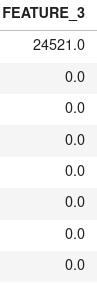

После их удаления останется 205 характеристик. Этого количества более чем достаточно для обучения моделей. Удалим их.

In [8]:
df.loc[:, (df != 0).any(axis=0)].shape

(24521, 205)

In [9]:
df = df.loc[:, (df != 0).any(axis=0)]

Проверим, есть ли наблюдения содержащие только нули. Как видим, после удаления таких наблюдений ничего не изменилось - значит их нет.

In [10]:
df[(df.T != 0).any()].shape

(24521, 205)

In [11]:
df.describe()

,ID,TARGET,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_9,...,FEATURE_248,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_257,FEATURE_258,FEATURE_259
count,2.452100e+04,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,...,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.00000,24521.000000
mean,1.393464e+09,0.352677,5.438196,1.337833,0.056401,0.141226,0.000163,0.011378,80.762084,0.383304,...,12.047959,41.057379,36.403205,307.827071,408.052350,0.611965,0.640390,1.138575,1.18580,1.184699
std,1.981725e+09,0.592092,14.533334,1.826413,0.230698,0.348262,0.012771,0.106061,256.605853,0.867586,...,34.038422,105.000146,105.872566,259.669681,349.968987,0.487312,0.479896,0.373638,0.40809,0.401288
min,1.428335e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-171.709797,0.000000,...,0.000000,-1256.000000,-667.000000,-1531.063435,-328.361649,0.000000,0.000000,1.000000,0.00000,1.000000
25%,4.503249e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.809139,0.000000,...,0.000000,0.000000,0.000000,129.829124,179.694989,0.000000,0.000000,1.000000,1.00000,1.000000
50%,7.449749e+08,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.673798,0.000000,...,1.000000,6.000000,0.000000,265.472906,326.928038,1.000000,1.000000,1.000000,1.00000,1.000000
75%,1.152479e+09,1.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,27.367809,0.000000,...,10.000000,39.000000,10.000000,408.197249,533.731611,1.000000,1.000000,1.000000,1.00000,1.000000
max,1.043892e+10,2.000000,385.000000,39.000000,1.000000,1.000000,1.000000,1.000000,3147.341440,11.000000,...,1483.000000,1775.000000,3194.000000,4202.905396,4440.534979,1.000000,1.000000,3.000000,3.00000,3.000000


Однако, так как в тестовой выборке тоже есть nan, лучше не удалять подобные колонки, а просто заполнить nan другими значениями, например, 0.

In [7]:
df = df_saved.fillna(0.)

In [8]:
df.shape

(24521, 262)

## Разделяем данные

Определим набор характеристик, по которым будем обучать модель - Х и целевую переменную (target) - y.

Для начала определим Х.

In [9]:
df.columns

Index(['ID', 'TARGET', 'FEATURE_0', 'FEATURE_1', 'FEATURE_2', 'FEATURE_3',
       'FEATURE_4', 'FEATURE_5', 'FEATURE_6', 'FEATURE_7',
       ...
       'FEATURE_250', 'FEATURE_251', 'FEATURE_252', 'FEATURE_253',
       'FEATURE_254', 'FEATURE_255', 'FEATURE_256', 'FEATURE_257',
       'FEATURE_258', 'FEATURE_259'],
      dtype='object', length=262)

In [10]:
X = df[df.columns[2:]]
X[0:5]

,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-114.527812,-17.218055,0.0,...,39.0,2.0,223.118594,290.015143,1.0,1.0,0.0,1.0,2.0,2.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,329.828334,0.000000,3.0,...,25.0,82.0,479.616045,611.651594,0.0,1.0,0.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,-6.680747,0.0,...,119.0,0.0,352.268014,564.573421,1.0,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.621397,36.659534,0.0,...,1.0,0.0,410.524985,421.653876,1.0,0.0,0.0,1.0,2.0,2.0
4,4.0,3.0,1.0,0.0,1.0,0.0,0.0,677.745861,0.000000,3.0,...,21.0,0.0,439.171356,476.189288,1.0,1.0,0.0,1.0,1.0,1.0


In [11]:
y = df["TARGET"].values
y[0:5]

array([1, 0, 1, 0, 0])

## Стандартизируем данные

Стандартизация данных дает нулевое среднее значение и единичную дисперсию, это хорошая практика, особенно для таких алгоритмов, как KNN, который основан на расстоянии наблюдений.

Для начала определим категориальные характеристики. **Категориальные характеристики** могут принимать только ограниченное и обычно фиксированное количество возможных значений. Например, если набор данных касается информации, связанной с пользователями: обычно такие характеристики, как страна, пол, возрастная группа и так далее. Их стандартизация приведет к потере смысла.

In [12]:
categorical_features = set()
for feature in X.columns: 
    if len(df[feature].value_counts()) <= 5:
        categorical_features.add(feature)
categorical_features

{'FEATURE_11',
 'FEATURE_123',
 'FEATURE_131',
 'FEATURE_140',
 'FEATURE_144',
 'FEATURE_15',
 'FEATURE_156',
 'FEATURE_157',
 'FEATURE_159',
 'FEATURE_16',
 'FEATURE_17',
 'FEATURE_18',
 'FEATURE_19',
 'FEATURE_2',
 'FEATURE_203',
 'FEATURE_204',
 'FEATURE_205',
 'FEATURE_206',
 'FEATURE_207',
 'FEATURE_208',
 'FEATURE_220',
 'FEATURE_249',
 'FEATURE_254',
 'FEATURE_255',
 'FEATURE_256',
 'FEATURE_257',
 'FEATURE_258',
 'FEATURE_259',
 'FEATURE_3',
 'FEATURE_4',
 'FEATURE_5',
 'FEATURE_6'}

В итоге, все, что не относятся к категориальным характеристикам, будут **непрерывными**. Это числовые переменные, которые имеют бесконечное количество значений между любыми двумя значениями.

In [13]:
numeric = [feature for feature in X.columns if feature not in categorical_features]

In [14]:
X[numeric] = preprocessing.StandardScaler().fit(X[numeric]).transform(X[numeric].astype(float))
X[0:5]

,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,-0.236578,0.362558,0.0,0.0,0.0,0.0,0.0,-0.761066,-0.239948,-0.441814,...,-0.019594,-0.324956,-0.326223,-0.337286,1.0,1.0,0.0,1.0,2.0,2.0
1,-0.305387,-0.184975,0.0,0.0,1.0,0.0,0.0,0.970638,-0.225349,3.016128,...,-0.152930,0.430685,0.661581,0.581776,0.0,1.0,0.0,1.0,1.0,1.0
2,-0.374195,-0.732507,0.0,0.0,0.0,0.0,0.0,-0.246822,-0.231014,-0.441814,...,0.742325,-0.343847,0.171148,0.447252,1.0,1.0,0.0,1.0,1.0,1.0
3,-0.305387,-0.184975,0.0,0.0,0.0,0.0,0.0,-0.222683,-0.194267,-0.441814,...,-0.381506,-0.343847,0.395503,0.038866,1.0,0.0,0.0,1.0,2.0,2.0
4,-0.098960,0.910091,1.0,0.0,1.0,0.0,0.0,2.326509,-0.225349,3.016128,...,-0.191026,-0.343847,0.505823,0.194698,1.0,1.0,0.0,1.0,1.0,1.0


Часто бывает так, что два признака, которые предназначались для измерения различных характеристик, находятся под влиянием какого-то общего механизма и имеют тенденцию изменяться вместе. Например, периметр и максимальная ширина фигуры будут варьироваться в зависимости от масштаба; большие фигуры будут иметь как большие периметры, так и большую максимальную ширину.

Это ухудшает производительность классификатора.

<AxesSubplot:>

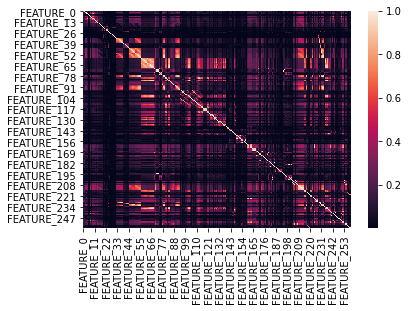

In [13]:
sns.heatmap(X.corr().abs())

In [20]:
def drop_correlated(df: pd.DataFrame, threshold=0.9):
    corr = df.corr().abs()
    mask = np.ones(corr.shape)
    triangular_mask = np.triu(mask, k=1).astype(np.bool)
    upper_triu = corr.where(triangular_mask)
    to_drop = [column for column in upper_triu.columns \
               if any(upper_triu[column] > threshold)]
    return df.drop(df[to_drop], axis=1)

Попробуем обучить на данных, не убирая коррелирующие фичи.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [22]:
X_test.shape, y_test.shape

((8092, 260), (8092,))

Попробуем оценить работу разных классификаторов: для этого воспользуемся кросс-валидацией на KFold.

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [25]:
models = {
    "KNN": KNeighborsClassifier(), 
    "SVM": SVC(), 
    "Multi-layer Perceptron classifier": MLPClassifier(), 
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(), 
    "XGBClassifier": XGBClassifier(),
}

In [26]:
for name, model in models.items():
    print_scores(name, model, X, y)

Model - KNN: F1(macro) - 0.371435597459337, Lift - 1.2948415402580735
Model - SVM: F1(macro) - 0.35886450721762014, Lift - 2.2902326243407014
Model - Multi-layer Perceptron classifier: F1(macro) - 0.4523033992866455, Lift - 1.3104949854843897
Model - RandomForestClassifier: F1(macro) - 0.3898306665483779, Lift - 1.5685407255783081
Model - LogisticRegression: F1(macro) - 0.4399018958881861, Lift - 1.8765419512255306
[02:47:50] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:48:40] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to r

## Выбираем threshold

Выбираем threshold - определяет, какая может быть максимальная корреляция между двумя характеристиками: возьму простую модель, чтобы оценить лучшее значение.

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

for trashold in np.linspace(0.1, 1., num=10):
    cleaned = drop_correlated(X, threshold=trashold)
    X_train, X_test, y_train, y_test = train_test_split(cleaned, y, test_size=0.33, stratify=y, random_state=42)
    LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
    yhat = LR.predict(X_test)
    print(f"Test set F1 for threshold - {trashold}: {metrics.f1_score(y_test, yhat, average='macro')}")

Test set F1 for threshold - 0.1: 0.277818259311895
Test set F1 for threshold - 0.2: 0.2774252560816206
Test set F1 for threshold - 0.30000000000000004: 0.27972416208177014
Test set F1 for threshold - 0.4: 0.29842312531704035
Test set F1 for threshold - 0.5: 0.36939772422003
Test set F1 for threshold - 0.6: 0.3749808253576124
Test set F1 for threshold - 0.7000000000000001: 0.3922929945267952
Test set F1 for threshold - 0.8: 0.4012474273283417
Test set F1 for threshold - 0.9: 0.4100674607537633
Test set F1 for threshold - 1.0: 0.4155604902741102


In [46]:
cleaned = drop_correlated(X, threshold=0.9)

<AxesSubplot:>

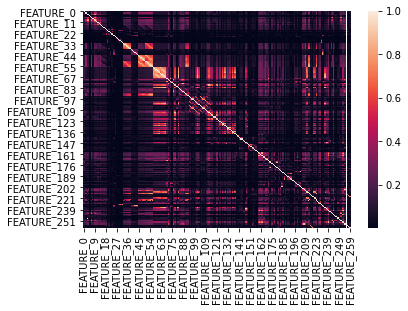

In [47]:
sns.heatmap(cleaned.corr().abs())

In [48]:
X = cleaned

In [49]:
X.shape

(24521, 217)

## Разделение на тренировочную и тестовую выборки

**Точность вне выборки** - это процент правильных прогнозов, которые модель делает на основе данных, на которых НЕ была обучена модель. Выполнение обучения и тестирования одного и того же набора данных, скорее всего, будет иметь низкую точность вне выборки из-за вероятности чрезмерного соответствия.

Важно, чтобы наши модели имели высокую точность вне выборки, потому что цель любой модели, конечно, состоит в том, чтобы делать правильные прогнозы на неизвестных данных. Итак, как мы можем улучшить точность вне выборки? Один из способов - использовать метод оценки, называемый разделением «Тренировочная / тестовая». Разделение на обучение / тестирование включает в себя разделение набора данных на обучающий и тестовый наборы соответственно, которые являются взаимоисключающими. После этого вы тренируетесь с обучающим набором и тестируете с помощью набора для тестирования.

Это обеспечит более точную оценку точности вне выборки, поскольку набор данных тестирования не является частью набора данных, который использовался для обучения данных. Это более реалистично для реальных проблем.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [16]:
X_test.shape, y_test.shape

((8092, 260), (8092,))

## Классификация

In [ ]:
Попробуем оценить работу разных классификаторов: для этого воспользуемся кросс-валидацией на KFold.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [ ]:
models = {
    "KNN": KNeighborsClassifier(), 
    "SVM": SVC(), 
    "Multi-layer Perceptron classifier": MLPClassifier(), 
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(), 
    "XGBClassifier": XGBClassifier(),
}

In [80]:
for name, model in models.items():
    print_scores(name, model, X, y)

Model - KNN: F1(macro) - 0.3695389287507235, Lift - 1.214369586085467
Model - SVM: F1(macro) - 0.3550094486927413, Lift - 2.4350076863314913
Model - Multi-layer Perceptron classifier: F1(macro) - 0.4584189833328307, Lift - 1.3134675605008879
Model - RandomForestClassifier: F1(macro) - 0.37926823500010126, Lift - 1.738526462717978
Model - LogisticRegression: F1(macro) - 0.43531464056259117, Lift - 1.9567868178388792
[19:49:34] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:50:15] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to r

Как видим, наилучшие результаты дает XGBClassifier: F1(macro) - 0.4710426653764586, Lift - 1.8082063926957632. Обучим эту модель на данных для обучения. Результаты остались такими же, как если бы я не удалял коррелирующие характеристики.

## XGBClassifier

Обучим модель и дальше будем использовать её для `contest_test.csv`

In [21]:
model = XGBClassifier()

In [22]:
X_train.shape

(16429, 260)

In [23]:
model.fit(X_train, y_train)

[21:22:26] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
yhat = model.predict(X_test)

In [26]:
print("Test set F1: ", f1_score(y_test, yhat, average='macro'))

Test set F1:  0.4628775953167339


## Загружаем тест и выводим результаты на лучшей модели

In [27]:
df_test = pd.read_csv ("contest_test.csv")
df_test.head()

,ID,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,1154270440,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-46.950807,-45.018511,...,0.0,0.0,190.587701,162.047775,1.0,0.0,1.0,1.0,1.0,1.0
1,1147987574,0.0,0.0,1.0,0.0,0.0,0.0,0.0,343.627489,NaN,...,5.0,109.0,594.572663,685.500149,1.0,1.0,0.0,1.0,1.0,2.0
2,1129622364,0.0,0.0,0.0,0.0,1.0,0.0,0.0,909.178045,3260.445427,...,0.0,297.0,10.214396,300.397949,0.0,0.0,0.0,1.0,1.0,1.0
3,619797496,6.0,2.0,0.0,0.0,0.0,0.0,0.0,-4.499021,-93.374738,...,1.0,2.0,334.873280,363.739214,1.0,1.0,1.0,2.0,2.0,1.0
4,7391484886,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-23.189787,-35.810318,...,83.0,136.0,551.413748,769.830050,1.0,1.0,0.0,1.0,1.0,1.0


In [28]:
df_test = df_test.fillna(0.)

In [29]:
X = df_test[df_test.columns[1:]]
X.head()

,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-46.950807,-45.018511,0.0,...,0.0,0.0,190.587701,162.047775,1.0,0.0,1.0,1.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,343.627489,0.000000,3.0,...,5.0,109.0,594.572663,685.500149,1.0,1.0,0.0,1.0,1.0,2.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,909.178045,3260.445427,3.0,...,0.0,297.0,10.214396,300.397949,0.0,0.0,0.0,1.0,1.0,1.0
3,6.0,2.0,0.0,0.0,0.0,0.0,0.0,-4.499021,-93.374738,0.0,...,1.0,2.0,334.873280,363.739214,1.0,1.0,1.0,2.0,2.0,1.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-23.189787,-35.810318,0.0,...,83.0,136.0,551.413748,769.830050,1.0,1.0,0.0,1.0,1.0,1.0


In [30]:
yhat = model.predict(X)

Получаем `contest_answer.csv`

In [31]:
X.shape

(9484, 260)

In [32]:
answer = pd.DataFrame({
    "ID": df_test["ID"], 
    "TARGET": yhat,
})
answer.head()

,ID,TARGET
0,1154270440,1
1,1147987574,2
2,1129622364,0
3,619797496,2
4,7391484886,2


In [33]:
answer.to_csv("contest_answer.csv", index=False)

Получаем `contest_segments.csv`

In [34]:
proba = model.predict_proba(X)

In [35]:
answer["PROBA"] = np.max(proba, axis=1)
answer.head()

,ID,TARGET,PROBA
0,1154270440,1,0.469359
1,1147987574,2,0.868437
2,1129622364,0,0.807798
3,619797496,2,0.502866
4,7391484886,2,0.856998


In [36]:
answer[answer["TARGET"] == 1].shape

(1925, 3)

In [37]:
second = answer[answer["TARGET"] == 1]
part1 = second.sort_values("PROBA", ascending=False)[:500]
part1.shape

(500, 3)

In [38]:
second = answer[answer["TARGET"] == 2]
part2 = second.sort_values("PROBA", ascending=False)[:200]
part2.shape

(200, 3)

In [39]:
result = pd.concat([part1, part2])
result = result.drop(columns={
    "PROBA"
})
result.shape

(700, 2)

In [40]:
result.head()

,ID,TARGET
8576,460916695,1
1674,435560377,1
6563,10436924517,1
1830,752352732,1
537,7454718934,1


In [41]:
result.to_csv("contest_segments.csv", index=False)